### Imports

In [112]:
import nltk
from nltk.corpus import semcor
import spacy
from nltk.corpus import wordnet as wn
import string
import json
import os

import polars as pl

import sys
sys.path.append('..')
from utils import utils as u

In [113]:
def get_synsets_at_level(node, target_level, current_level=0):
    if current_level == target_level:
        # Aggiunto il lemma del senso corrente
        return [node.lemmas()[0].name()]

    results = []
    for hyponym in node.hyponyms():
        results.extend(get_synsets_at_level(
            hyponym, target_level, current_level + 1))

    return results


def get_wordnet_lemmas_at_depth(target_level):
    root = wn.synset('entity.n.01')  # La radice di WordNet
    return get_synsets_at_level(root, target_level)

### Struttura dati per supersensi WordNet



In [114]:
WORDNET_SUPERSENSES = get_wordnet_lemmas_at_depth(2)

WORDNET_SUPERSENSES_SYNSETS = {}

for word in WORDNET_SUPERSENSES:
    WORDNET_SUPERSENSES_SYNSETS[word] = wn.synsets(word, 'n')


In [115]:
len(WORDNET_SUPERSENSES_SYNSETS)

22

### Scelgo il verbo 

In [116]:

verb = 'find'


### Recupero da un corpus tutte le frasi che lo contengono

In [117]:


nlp = spacy.load("en_core_web_sm")

sentences = semcor.sents()

### Converto le liste di token in stringhe ottenento quindi una lista di frasi

In [118]:
file_name = 'corpus.json'

if os.path.exists(file_name):
    with open(file_name, 'r') as file:
        corpus = json.load(file)
else:

    corpus = []
    for sentence in sentences:

        str_sent = ""
        for token in sentence:

            if token.startswith(tuple(string.punctuation)):
                str_sent += token
            else:
                str_sent += ' '+token
        str_sent = str_sent.replace("''", "")
        str_sent = str_sent.replace("``", "")

        doc = nlp(str_sent)
        if any(token.lemma_ == verb for token in doc):
            corpus.append(str_sent)

    with open(file_name, 'w') as file:
        json.dump(corpus, file)


In [119]:
corpus

[" The jury said it did find that many of Georgia's registration and election laws are outmoded or inadequate and often ambiguous.",
 ' The jury said it found the court has incorporated into its operating procedures the recommendations of two previous grand juries, the Atlanta Bar Association and an interim citizens committee.',
 " Buffalo coach Buster Ramsey, who has become one of the game's greatest collectors of quarterbacks, apparently now has found a productive pair in two ex National Football Leaguers, M. C. Reynolds and Warren Rabb.",
 " The Giants who had been anemic with the bat in their windy Candlestick Park suddenly found the formula in Milwaukee's park.",
 ' If there had been, he would have found a loophole, because Arnold is one golfer who knows the code as thoroughly as the man who wrote the book.',
 ' Several times I found the players pepping me up, where it usually is the coach who is supposed to deliver the fight talk.',
 ' St. Louis University found a way to win a ba

### Pero ogni frase, vado a ricavare soggetto e oggetto, se legati dal verbo scelto precedentemente, e mi salvo in un dizionario i synsets di entrambi

In [120]:
semantic_roles = {}
i = 1
for sentence in corpus:
    doc = nlp(sentence)
    # Estrai ruoli sintattici e tipi semantici
    obj_synset = []
    subj_synset = []
    for token in doc:

        if token.dep_ == "nsubj":
            word = u.lemmatize_word(token.text, 'n')
            subj_synset = wn.synsets(word, 'n')
        if token.dep_ == "dobj":
            word = u.lemmatize_word(token.text, 'n')
            obj_synset = wn.synsets(word, 'n')

        if len(obj_synset) > 0 and len(subj_synset) > 0:
            # Mappatura a tipi semantici utilizzando WordNet (solo come esempio)
            semantic_roles[i] = {}
            semantic_roles[i]['nsubj'] = subj_synset
            semantic_roles[i]['dobj'] = obj_synset
    i += 1


### Funzione per ricavare i supersensi dato un senso

In [121]:
def get_supersenses(sense):
    senses = [sense]
    supersenses_list = {}

    while senses:
        #print(senses)
        current_synset = senses.pop(0)

        for word in WORDNET_SUPERSENSES_SYNSETS:

            if current_synset in WORDNET_SUPERSENSES_SYNSETS[word]:
                if word not in supersenses_list:
                    supersenses_list[word] = 1
                else:
                    supersenses_list[word] += 1

        hypernyms = current_synset.hypernyms()
    
        senses.extend(hypernyms)
    if len(supersenses_list) > 0:
        return supersenses_list
    else:
        return None




### Per ogni coppia sogetto, oggetto vado a prendere i supersenses e li aggiungo a una lista mantenendo l'id della frase in cui compaiono

In [122]:
supersenses_subj_obj = {}
for index in semantic_roles:
    supersenses_subj_obj[index] = []
    if 'nsubj' in semantic_roles[index].keys() and 'dobj' in semantic_roles[index].keys():
        for synset_subj in semantic_roles[index]['nsubj']:
            supersenses_subj = get_supersenses(synset_subj)
            if supersenses_subj is not None:
                max_value_sssubj = max(supersenses_subj.values())
                for sub_supersense in supersenses_subj:
                    if supersenses_subj[sub_supersense] == max_value_sssubj:
                        for synset_obj in semantic_roles[index]['dobj']:
                            supersenses_obj = get_supersenses(synset_obj)
                            if supersenses_obj is not None:
                                max_value_ssobj = max(supersenses_obj.values())
                                for obj_supersense in supersenses_obj:
                                    if supersenses_obj[obj_supersense] == max_value_ssobj:
                                        if supersenses_subj is not None and supersenses_obj is not None:
                                            supersenses_subj_obj[index].append(
                                                (sub_supersense, obj_supersense))
    supersenses_subj_obj[index] = list(set(supersenses_subj_obj[index]))


### Per ogni coppia di supersensi soggetto-oggetto per il verbo scelto mi salvo gli indici delle frasi un cui compare 

In [123]:
semantic_patterns = {}
for index in supersenses_subj_obj:
    for couple in supersenses_subj_obj[index]:
        if couple not in semantic_patterns:
            semantic_patterns[couple] = [index]
        else:
            semantic_patterns[couple] += [index]

semantic_patterns = dict(
    sorted(semantic_patterns.items(), key=lambda item: len(item[1]), reverse=True))

for key in semantic_patterns:
    print(key, len(semantic_patterns[key]))



tab = pl.DataFrame()


('communication', 'psychological_feature') 91
('psychological_feature', 'psychological_feature') 86
('matter', 'psychological_feature') 78
('psychological_feature', 'attribute') 69
('communication', 'object') 69
('matter', 'object') 64
('object', 'psychological_feature') 61
('group', 'psychological_feature') 58
('psychological_feature', 'object') 57
('object', 'object') 55
('group', 'object') 53
('communication', 'attribute') 50
('object', 'attribute') 49
('psychological_feature', 'communication') 45
('communication', 'communication') 44
('matter', 'attribute') 43
('relation', 'object') 40
('measure', 'psychological_feature') 39
('group', 'attribute') 38
('relation', 'psychological_feature') 37
('psychological_feature', 'relation') 35
('substance', 'psychological_feature') 35
('matter', 'communication') 35
('object', 'communication') 34
('substance', 'object') 34
('group', 'communication') 33
('measure', 'object') 30
('causal_agent', 'psychological_feature') 29
('measure', 'attribute')

### Stampo i risultati

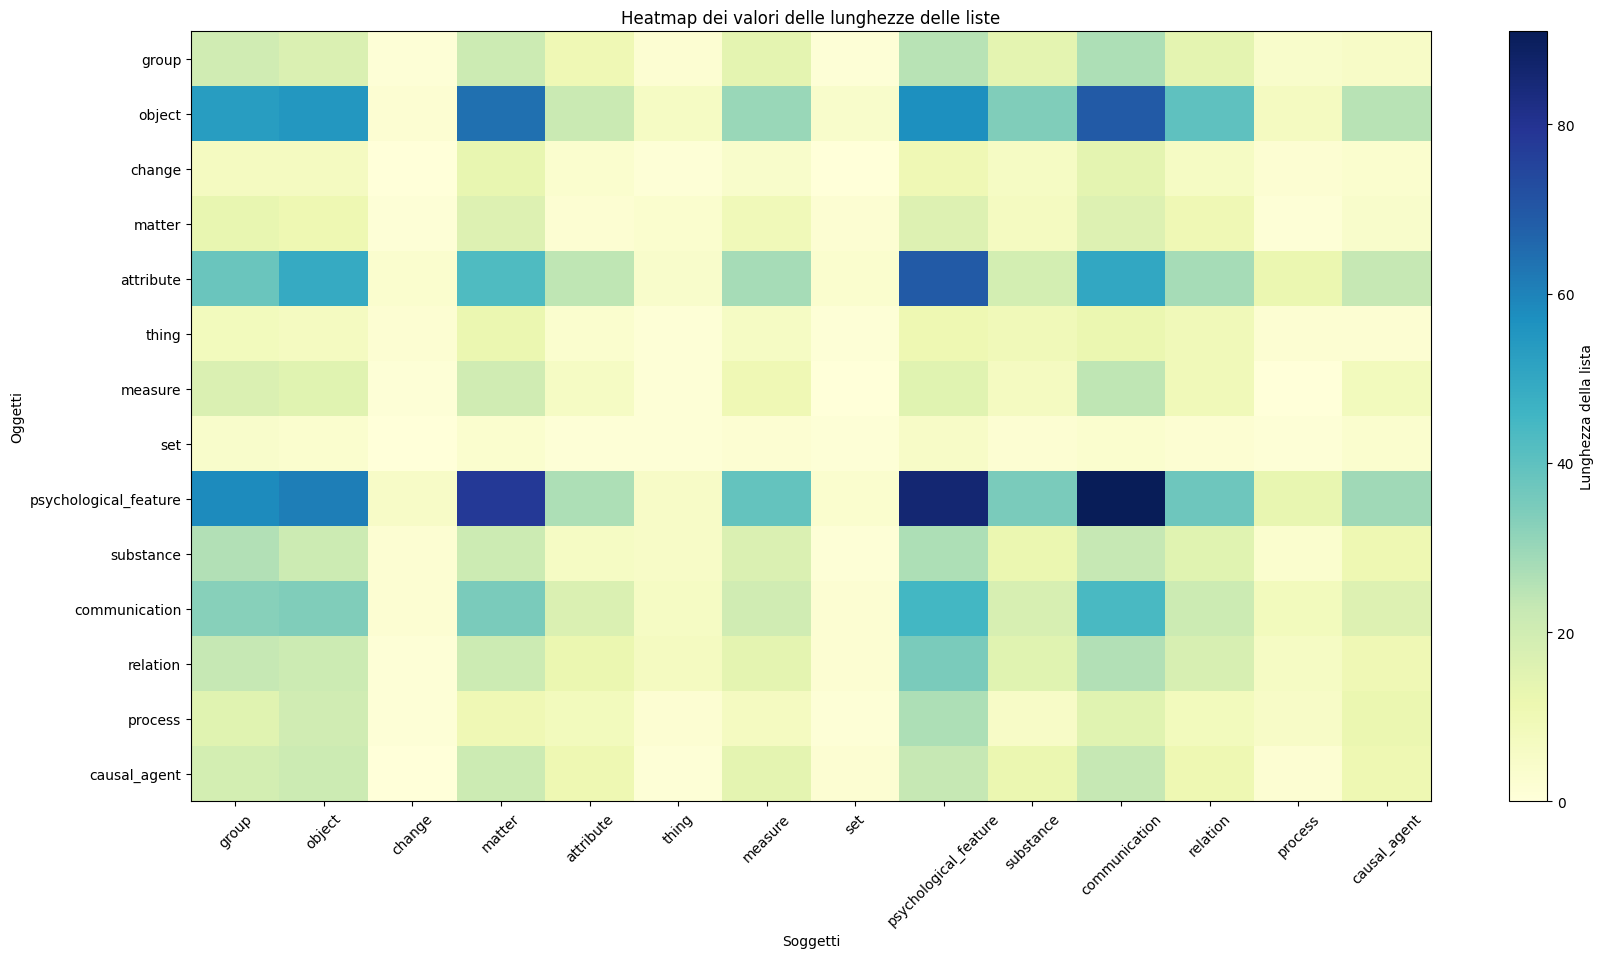

In [124]:
import pandas as pd

# I tuoi dati
dati = []

for key in semantic_patterns:
    dati.append(((key[0], key[1]), semantic_patterns[key]))

# Estrai l'elenco completo di primi e secondi elementi
primi_elementi = list(set([coppia[0] for coppia, _ in dati]))
secondi_elementi = list(set([coppia[1] for coppia, _ in dati]))

# Creazione del DataFrame
df = pd.DataFrame(columns=primi_elementi, index=secondi_elementi)

# Riempi il DataFrame con i valori delle lunghezze delle liste
for coppia, lista in dati:
    primi_elem = coppia[0]
    secondo_elem = coppia[1]
    valore = len(lista)
    df.loc[secondo_elem, primi_elem] = valore

# Visualizzazione del DataFrame
import matplotlib.pyplot as plt

# ... (Codice per creare il DataFrame)


df = df.fillna(0)
# Esempio 1: Heatmap
plt.figure(figsize=(20, 10))
plt.title('Heatmap dei valori delle lunghezze delle liste')
plt.xlabel('Soggetti')
plt.ylabel('Oggetti')
plt.imshow(df, cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Lunghezza della lista')
plt.xticks(ticks=range(len(primi_elementi)), labels=primi_elementi, rotation=45)
plt.yticks(ticks=range(len(secondi_elementi)), labels=secondi_elementi)
plt.show()
